In [5]:
!pip install -qU langchain langsmith langchain-core langchain-community langchain-experimental langchain-openai langchain-groq pypdf langchain-text-splitters langchain-chroma faiss-cpu sentence_transformers google-search-results wikipedia duckduckgo-search arxiv langgraph

# Load Envs

In [2]:
import os
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HUGGINGFACEHUB_API_TOKEN')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
# os.environ['SERPAPI_API_KEY'] = userdata.get('SERPAPI_API_KEY')

# Setup Langsmith

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langgraph_learning"

# LangGraph

* LangGraph is a library(low-level framework) for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.

* LangGraph allows you to define flows that involve cycles (`DCG`-based), essential for most agentic architectures, differentiating it from `DAG`-based solutions.

* Made up of nodes and edges.

* Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

* When defining a graph, the first step is to define its `State`. The `State` includes the graph's schema and reducer functions that handle `state` updates.

  In our example, `State` is a `TypedDict` with one key: messages.
  
  The `add_messages` reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values.

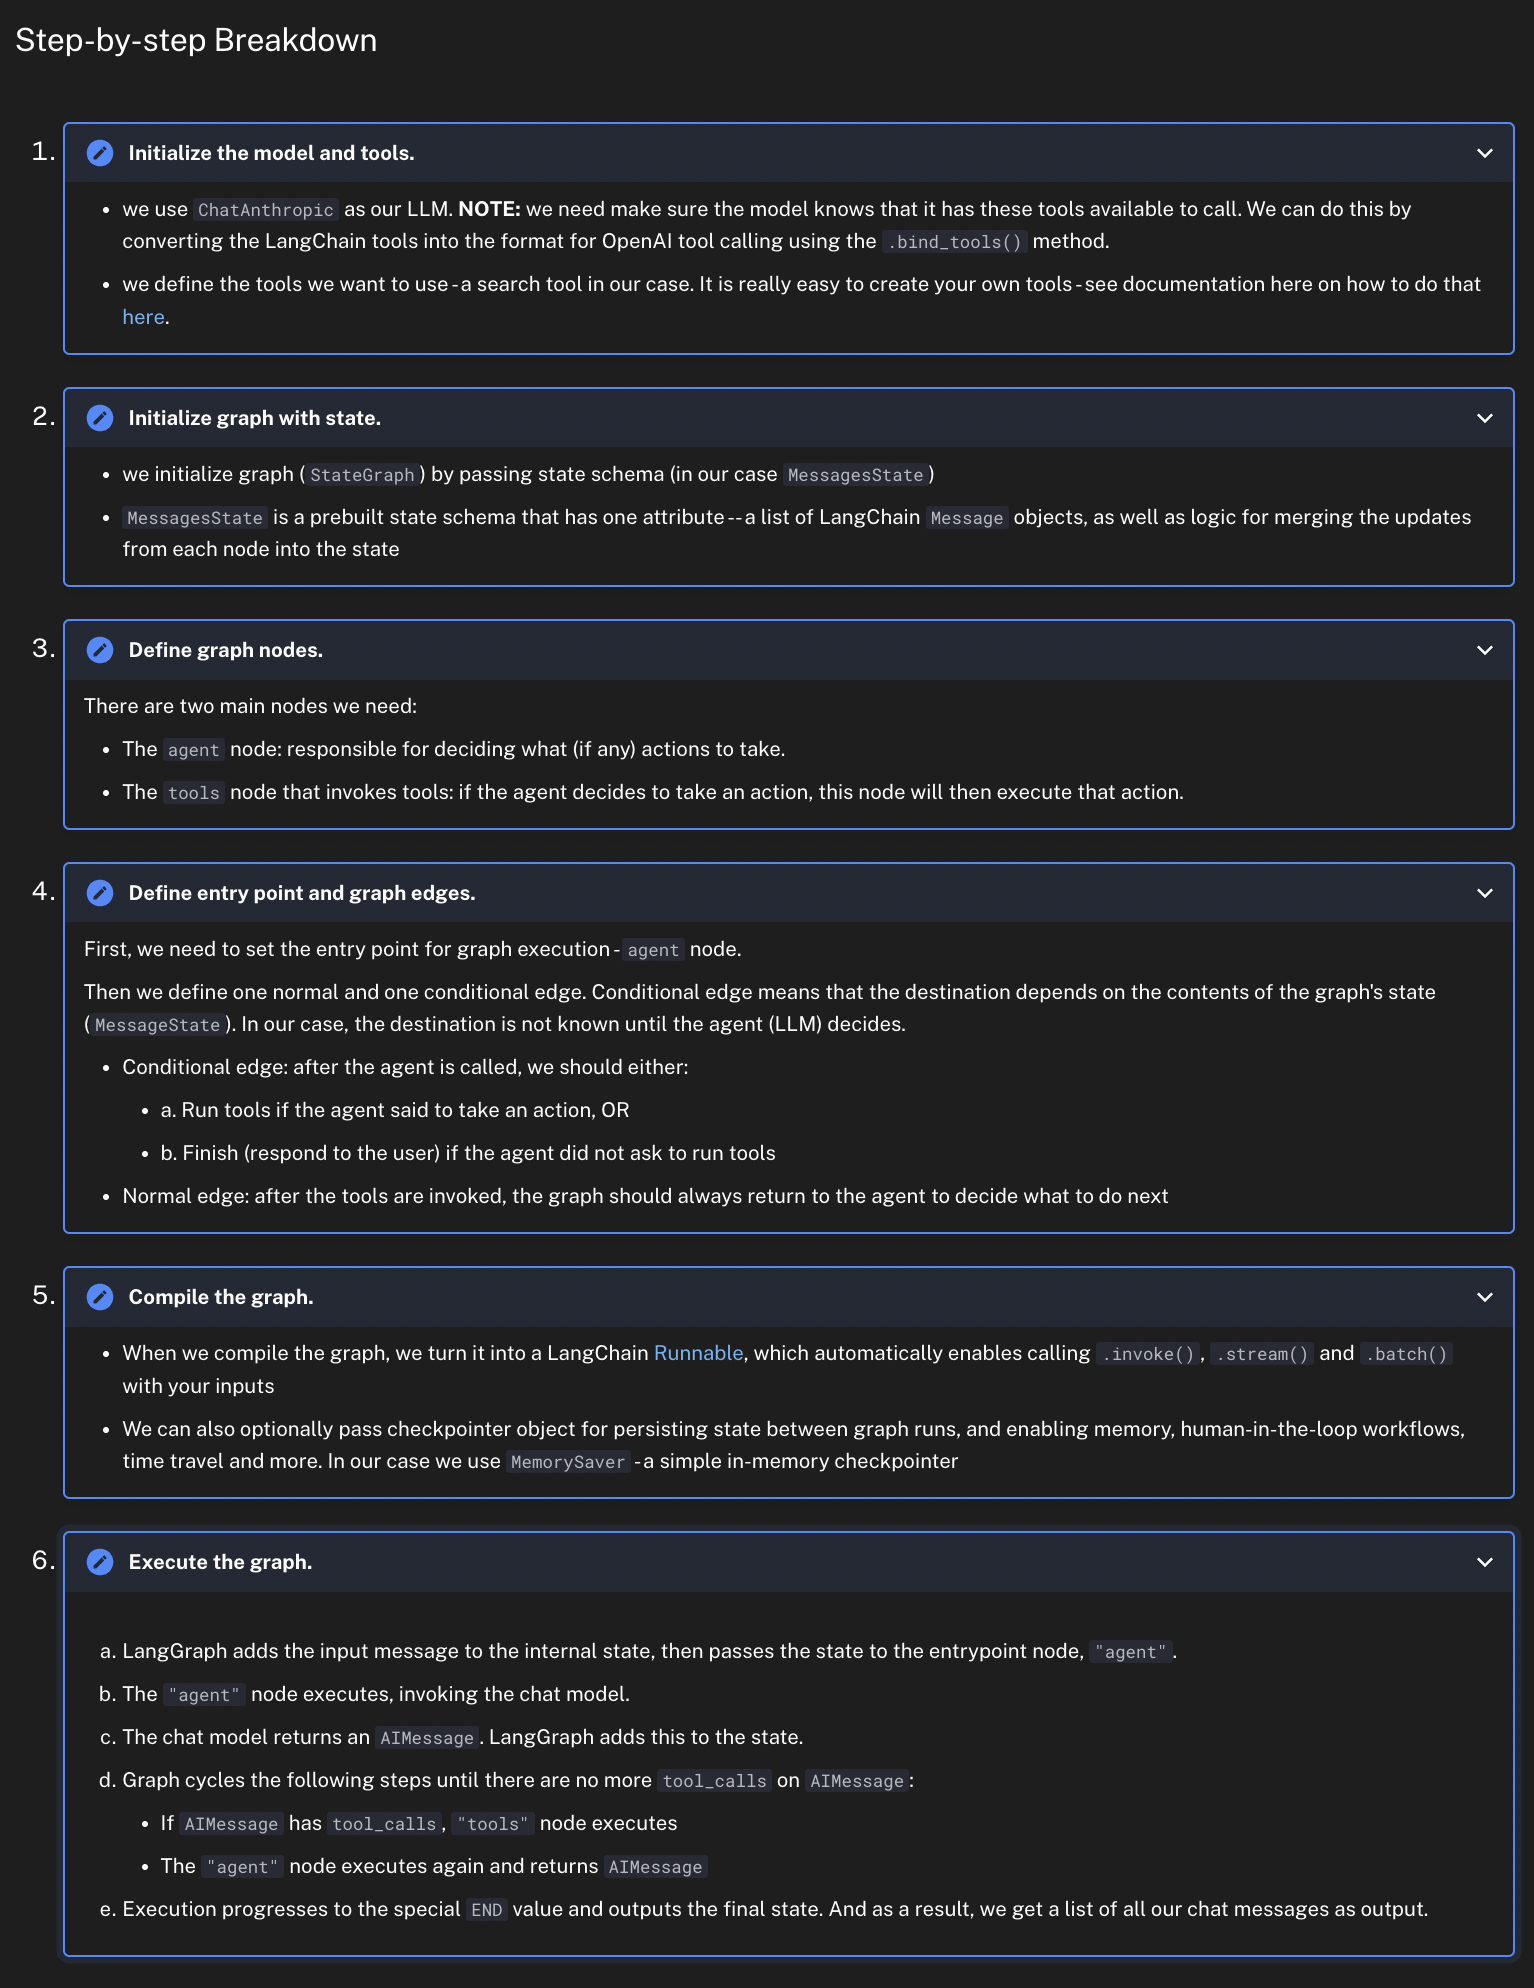

# State in LangGraph

1. TypedDict:

  TypedDict is a special type that allows you to define a dictionary in Python where each key has a specific type.
  
  It’s useful when you want to enforce type checks on the keys and values of a dictionary.

2. Annotated:

  Annotated is used to add metadata or constraints to a type.
  
  It’s typically used for adding additional information, like constraints or descriptions, to the type.

3. Sequence[BaseMessage]:

  Sequence is a generic type from Python's typing module that represents a list-like structure (such as a list or tuple) where the order matters, and you can access elements by their position.

4. BaseMessage:

  This assumes you're working with the LangChain framework, and BaseMessage is part of its core messaging system.
  
  It is typically used when handling or processing messages in LangChain's workflows

5. operator.add:

  operator.add is a function from Python’s operator module that performs addition (+) on its arguments.
  
  In this context, operator.add is being used as metadata for the Annotated type, likely suggesting that the sequence of BaseMessage objects is meant to be "added" or concatenated with another sequence at some point.
  
  It’s an indicator of how the messages field will be treated in the logic of your program.

# Basic RAG

In [6]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

In [7]:
# Load document
loader = PyPDFLoader("/content/FoodAdvisor.pdf")
pages = loader.load()

# Split Texts
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)


docs = text_splitter.split_documents(pages)

# Embedding Model
embeddings_model = OpenAIEmbeddings()

persist_directory="./chroma_db"

if os.path.isdir(persist_directory):
  # Load from disk
  db = Chroma(persist_directory=persist_directory, embedding_function=embeddings_model)
else:
  # Store on disk
  db = Chroma.from_documents(docs, embeddings_model, persist_directory=persist_directory)


# Retreiver
retriever = db.as_retriever()


In [8]:
docs = retriever.invoke("what are some Restaurants in Jayanagar")
len(docs)

4

In [9]:
docs

[Document(metadata={'page': 0, 'source': '/content/FoodAdvisor.pdf'}, page_content='1.Restaurants in Jayanagar\n    Breakfast Restaurants in Jayanagar for South Indian Breakfast \nTiming from 7 AM to 11 AM\n• Bangalore Cafe\n• Brahmin Tiffins and Coffee\n• Davanagere Benne Dosa\n• Taaza Tindi\n• Dosa Camp\n    Lunch/Dinner Restaurants for Vegetarians for South Indian, Chinese \nand North Indian food in Jayanagar from 12 PM to 3PM and 7 PM to 10 PM \n• Upahara Darshini\n• Maiyas\n• Paakashala\n• Basaveshwara Khanavali\n• Subz\n• Thyme and whisk\n• Kapoors Cafe \n• 1947\n• Ishta\n• Desi Masala\n    Lunch/dinner for both Vegetarians and Non-Vegetarians for South \nIndian, Chinese and North Indian food in Jayanagar from 12 PM to 3PM \nand 7 PM to 10 PM \n• Nagarjuna\n• Nandhana Palace\n• Andhra Ruchulu\n• Meghana Foods\n• Halli Donne Biryani\n• Aromas of Biryani\n• Chungs\n• Pasta Street\n• Chutney Chang\n     Food joints for Evening Snacks in Jayanagar from 4 PM to 10 PM\n• Karnataka Bhel

In [11]:
docs[0].page_content

'1.Restaurants in Jayanagar\n    Breakfast Restaurants in Jayanagar for South Indian Breakfast \nTiming from 7 AM to 11 AM\n• Bangalore Cafe\n• Brahmin Tiffins and Coffee\n• Davanagere Benne Dosa\n• Taaza Tindi\n• Dosa Camp\n    Lunch/Dinner Restaurants for Vegetarians for South Indian, Chinese \nand North Indian food in Jayanagar from 12 PM to 3PM and 7 PM to 10 PM \n• Upahara Darshini\n• Maiyas\n• Paakashala\n• Basaveshwara Khanavali\n• Subz\n• Thyme and whisk\n• Kapoors Cafe \n• 1947\n• Ishta\n• Desi Masala\n    Lunch/dinner for both Vegetarians and Non-Vegetarians for South \nIndian, Chinese and North Indian food in Jayanagar from 12 PM to 3PM \nand 7 PM to 10 PM \n• Nagarjuna\n• Nandhana Palace\n• Andhra Ruchulu\n• Meghana Foods\n• Halli Donne Biryani\n• Aromas of Biryani\n• Chungs\n• Pasta Street\n• Chutney Chang\n     Food joints for Evening Snacks in Jayanagar from 4 PM to 10 PM\n• Karnataka Bhel House\n• Taaza Tindi\n• Bangalore Cafe\n     Restaurants/ Pubs serving hot drinks 

In [12]:
for doc in docs:
  print(doc.page_content)
  print("\n\n")

1.Restaurants in Jayanagar
    Breakfast Restaurants in Jayanagar for South Indian Breakfast 
Timing from 7 AM to 11 AM
• Bangalore Cafe
• Brahmin Tiffins and Coffee
• Davanagere Benne Dosa
• Taaza Tindi
• Dosa Camp
    Lunch/Dinner Restaurants for Vegetarians for South Indian, Chinese 
and North Indian food in Jayanagar from 12 PM to 3PM and 7 PM to 10 PM 
• Upahara Darshini
• Maiyas
• Paakashala
• Basaveshwara Khanavali
• Subz
• Thyme and whisk
• Kapoors Cafe 
• 1947
• Ishta
• Desi Masala
    Lunch/dinner for both Vegetarians and Non-Vegetarians for South 
Indian, Chinese and North Indian food in Jayanagar from 12 PM to 3PM 
and 7 PM to 10 PM 
• Nagarjuna
• Nandhana Palace
• Andhra Ruchulu
• Meghana Foods
• Halli Donne Biryani
• Aromas of Biryani
• Chungs
• Pasta Street
• Chutney Chang
     Food joints for Evening Snacks in Jayanagar from 4 PM to 10 PM
• Karnataka Bhel House
• Taaza Tindi
• Bangalore Cafe
     Restaurants/ Pubs serving hot drinks with all varieties of food



Food jo

###  Build Chain

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

In [17]:
from langchain_groq import ChatGroq

llm = ChatGroq(model = 'llama-3.1-8b-instant')

`classmethod from_template(template: str, **kwargs: Any) → ChatPromptTemplate`[source](https://python.langchain.com/api_reference/_modules/langchain_core/prompts/chat.html#ChatPromptTemplate.from_strings)

Create a chat prompt template from a template string.

Creates a chat template consisting of a single message assumed to be from the human.

In [22]:
template = """Answer the question based only on the following context:
{context}

Question: {question}

Note: Never state anywhere in your conversation that the answers are from the context.
"""

prompt = ChatPromptTemplate.from_template(template)

In [23]:
def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)


In [24]:
rag_chain = (
    {"context" : retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)


In [25]:
result = rag_chain.invoke("what are some Restaurants in Jayanagar")

In [26]:
print(result)

In Jayanagar, some restaurants include:

1. Upahara Darshini
2. Maiyas
3. Paakashala
4. Basaveshwara Khanavali
5. Subz
6. Thyme and whisk
7. Kapoors Cafe
8. 1947
9. Ishta
10. Desi Masala
11. Nagarjuna
12. Nandhana Palace
13. Andhra Ruchulu
14. Meghana Foods
15. Halli Donne Biryani
16. Aromas of Biryani
17. Chungs
18. Pasta Street
19. Chutney Chang
20. Karnataka Bhel House
21. Taaza Tindi
22. Bangalore Cafe
23. Gustoes
24. Rooftop Cafe
25. Stories
26. Biergarten
27. Corner House
28. Cool joint
29. Tea Villa Cafe
30. Ground Up Coffee and Roastery


In [27]:
result = rag_chain.invoke("what are some Restaurants famous for its signature food in Malleswaram")
print(result)

Veena Stores- is a must try for authentic south Indian breakfast especially hot idlis with chutney.
 CTR- is a must try mouth watering Dosa with hot coffee.
 The Green Path Organic - must try organic food with amazing desserts
 Jetlag - wonderful food with amazing view


# Memory

## what is the work of an agent state?
> The work of AgentState is to just pass the message from one node to the next node.

Think of it as a dictionary storing values.

In [39]:
from collections import defaultdict
dic = defaultdict(list)

In [40]:
dic["messages"].append("hi, how are you?")
print(dic)

defaultdict(<class 'list'>, {'messages': ['hi, how are you?']})


In [41]:
dic["messages"].append("I am fine, thank you, How are you?")
print(dic)

defaultdict(<class 'list'>, {'messages': ['hi, how are you?', 'I am fine, thank you, How are you?']})


In [43]:
dic["messages"][-1]

'I am fine, thank you, How are you?'

In [44]:
from collections import defaultdict
dic = defaultdict(list)

In [45]:
dic["user_1"].append("hi, how are you?")
print(dic)

defaultdict(<class 'list'>, {'user_1': ['hi, how are you?']})


In [46]:
dic["user_2"].append("I am fine, thank you, How are you?")
print(dic)

defaultdict(<class 'list'>, {'user_1': ['hi, how are you?'], 'user_2': ['I am fine, thank you, How are you?']})


In [47]:
dic["user_1"].append("What plans for the weekend?")
print(dic)

defaultdict(<class 'list'>, {'user_1': ['hi, how are you?', 'What plans for the weekend?'], 'user_2': ['I am fine, thank you, How are you?']})


In [48]:
dic["user_2"].append("NM, HBU?")
print(dic)

defaultdict(<class 'list'>, {'user_1': ['hi, how are you?', 'What plans for the weekend?'], 'user_2': ['I am fine, thank you, How are you?', 'NM, HBU?']})


In [49]:
dic["user_1"][-1] # latest message

'What plans for the weekend?'

In [50]:
dic["user_2"][-1] # latest message

'NM, HBU?'

# Langgraph - Building memory from scratch with LLM and RAG Tool.

### Adding AgentState

In [194]:
from collections import defaultdict
Agent_State = defaultdict(list)

### RAG Tool

In [195]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

In [196]:
# Load document
loader = PyPDFLoader("/content/FoodAdvisor.pdf")
pages = loader.load()

# Split Texts
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)


docs = text_splitter.split_documents(pages)

# Embedding Model
embeddings_model = OpenAIEmbeddings()

persist_directory="./chroma_db"

if os.path.isdir(persist_directory):
  # Load from disk
  db = Chroma(persist_directory=persist_directory, embedding_function=embeddings_model)
else:
  # Store on disk
  db = Chroma.from_documents(docs, embeddings_model, persist_directory=persist_directory)


# Retreiver
retriever = db.as_retriever()

In [197]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

In [198]:
from langchain_groq import ChatGroq

llm = ChatGroq(model = 'llama-3.1-8b-instant')

In [199]:
def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)

In [200]:
template = """
  Answer the question based only on the following context:
  {context}

  Question: {question}

  Note: Never state anywhere in your conversation that the answers are from the context.
"""

In [201]:
def rag_function(llm_response):
  print("response from previous node: ", llm_response)

  question = Agent_State["user_message"][-1]
  print(question)

  prompt = ChatPromptTemplate.from_template(template)

  rag_chain = (
    {"context" : retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
  )

  result = rag_chain.invoke(question)
  print("rag_result: ", result)

  Agent_State["agent_response"].append(result)

  return result



### LLM Tool

In [202]:
def llm_function(query):
  print("llm query: ", query)

  user_query = Agent_State["user_message"][-1]
  print(user_query)

  prompt = "Briefly answer the question in one or two line about user query. user_query: {}".format(user_query)

  llm_response = llm.invoke(prompt)
  result = llm_response.content
  print("llm result: ",result)

  Agent_State["agent_response"].append(result)
  return result

# Build Graph

In [203]:
from langgraph.graph import END, START, Graph

# 1. Create Instance of the Graph
workflow = Graph()

# 2. Create Nodes
workflow.add_node("LLM_Tool", llm_function)
workflow.add_node("RAG_Tool", rag_function)

# 3. Create Edge
workflow.add_edge("LLM_Tool", "RAG_Tool")

## Create Entry Points
workflow.add_edge(START, "LLM_Tool")
workflow.add_edge("RAG_Tool", END)

# 4. Compile the graph
my_graph = workflow.compile()

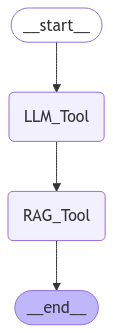

In [204]:
# 5. Display the graph
from IPython.display import Image, display

try:
    display(Image(my_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [205]:
# Step 6: Run the graph

user_input = "Name few Restaurants in Malleswaram serving Vegetarian food"
Agent_State["user_message"].append(user_input)

print(Agent_State)

defaultdict(<class 'list'>, {'user_message': ['Name few Restaurants in Malleswaram serving Vegetarian food']})


In [206]:
query = Agent_State["user_message"]

# result = my_graph.invoke(query)

for output in my_graph.stream(query):
  for key,value in output.items():
    print(f"here is output from {key}:")
    print(value)
    print("_______")
    print("\n")

llm query:  ['Name few Restaurants in Malleswaram serving Vegetarian food']
Name few Restaurants in Malleswaram serving Vegetarian food
llm result:  In Malleswaram, some popular vegetarian restaurants include Shri Sainath Pure Veg, Kamat Upachar, and Adigas. These restaurants offer a variety of South Indian and North Indian dishes.
here is output from LLM_Tool:
In Malleswaram, some popular vegetarian restaurants include Shri Sainath Pure Veg, Kamat Upachar, and Adigas. These restaurants offer a variety of South Indian and North Indian dishes.
_______


response from previous node:  In Malleswaram, some popular vegetarian restaurants include Shri Sainath Pure Veg, Kamat Upachar, and Adigas. These restaurants offer a variety of South Indian and North Indian dishes.
Name few Restaurants in Malleswaram serving Vegetarian food
rag_result:  Here are a few restaurants in Malleswaram serving vegetarian food:

1. Kadamba
2. Swati
3. Hallimane
4. Shiv Sagar
5. 1947
6. The Green Path Organic
7. M

# In the above example there was an state that was maintained outside but was not passed between the nodes.

The above example was to show output form node 1 gets passed to node 2 as input.

## Agent State

In [220]:
from collections import defaultdict
Agent_State = defaultdict(list)

## Tools

In [221]:
def llm_function(Agent_State):
  print("llm state: ", Agent_State)

  user_query = Agent_State["messages"][-1]
  print(user_query)

  prompt = "Briefly answer the question in one or two line about user query. user_query: {}".format(user_query)

  llm_response = llm.invoke(prompt)
  result = llm_response.content
  print("llm result: ",result)

  Agent_State["messages"].append(result)

  return Agent_State # previously we used to return result of llm , here we pass the dictionary itself

In [222]:
def rag_function(Agent_State):
  print("RAG state: ", Agent_State)

  question = Agent_State["messages"][0]
  print(question)

  prompt = ChatPromptTemplate.from_template(template)

  rag_chain = (
    {"context" : retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
  )

  result = rag_chain.invoke(question)
  print("rag_result: ", result)

  Agent_State["messages"].append(result)

  return result

## Build Graph

In [223]:
from langgraph.graph import END, START, Graph

# 1. Create Instance of the Graph
workflow = Graph()

# 2. Create Nodes
workflow.add_node("LLM_Tool", llm_function)
workflow.add_node("RAG_Tool", rag_function)

# 3. Create Edge
workflow.add_edge("LLM_Tool", "RAG_Tool")

## Create Entry Points
workflow.add_edge(START, "LLM_Tool")
workflow.add_edge("RAG_Tool", END)

# 4. Compile the graph
my_graph = workflow.compile()

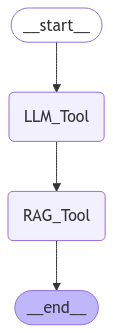

In [224]:
# 5. Display the graph
from IPython.display import Image, display

try:
    display(Image(my_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [225]:
# Agent State
query = {"messages" : ["Name few Restaurants in Malleswaram serving Vegetarian food"]}


result = my_graph.invoke(query)

llm state:  {'messages': ['Name few Restaurants in Malleswaram serving Vegetarian food']}
Name few Restaurants in Malleswaram serving Vegetarian food
llm result:  Some popular restaurants in Malleswaram serving vegetarian food include Shri Sagar, Kamath Lokaruchi, and Adigas. These restaurants offer a variety of South Indian and North Indian vegetarian dishes.
RAG state:  {'messages': ['Name few Restaurants in Malleswaram serving Vegetarian food', 'Some popular restaurants in Malleswaram serving vegetarian food include Shri Sagar, Kamath Lokaruchi, and Adigas. These restaurants offer a variety of South Indian and North Indian vegetarian dishes.']}
Name few Restaurants in Malleswaram serving Vegetarian food
rag_result:  Here are a few restaurants in Malleswaram serving Vegetarian food:

1. Kadamba
2. Swati
3. Hallimane
4. Shiv Sagar
5. Al-Bek
6. Karnataka Biryani Point
7. Donne Biryani House
8. CTR
9. Brahmins Tatte Idli
10. The Green Path Organic 
11. Mint Masala


## We can also use seperate names in dictionary if needed.

## Adding Agent State

In [226]:
from collections import defaultdict
Agent_State = defaultdict(list)

## Tools

### RAG Tool

In [227]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

In [228]:
# Load document
loader = PyPDFLoader("/content/FoodAdvisor.pdf")
pages = loader.load()

# Split Texts
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)


docs = text_splitter.split_documents(pages)

# Embedding Model
embeddings_model = OpenAIEmbeddings()

persist_directory="./chroma_db"

if os.path.isdir(persist_directory):
  # Load from disk
  db = Chroma(persist_directory=persist_directory, embedding_function=embeddings_model)
else:
  # Store on disk
  db = Chroma.from_documents(docs, embeddings_model, persist_directory=persist_directory)


# Retreiver
retriever = db.as_retriever()

In [229]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

In [230]:
from langchain_groq import ChatGroq

llm = ChatGroq(model = 'llama-3.1-8b-instant')

In [231]:
def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)

In [232]:
template = """
  Answer the question based only on the following context:
  {context}

  Question: {question}

  Note: Never state anywhere in your conversation that the answers are from the context.
"""

In [233]:
def rag_function(Agent_State):
  question = Agent_State["user_message"][-1]

  prompt = ChatPromptTemplate.from_template(template)

  rag_chain = (
    {"context" : retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
  )

  result = rag_chain.invoke(question)

  Agent_State["agent_response"].append(result)

  return result



### LLM Tool

In [234]:
def llm_function(Agent_State):
  user_query = Agent_State["user_message"][-1]

  prompt = "Briefly answer the question in one or two line about user query. user_query: {}".format(user_query)

  llm_response = llm.invoke(prompt)
  result = llm_response.content

  Agent_State["agent_response"].append(result)

  return Agent_State # pass the state to next node

## Build Graph

In [235]:
from langgraph.graph import END, START, Graph

# 1. Create Instance of the Graph
workflow = Graph()

# 2. Create Nodes
workflow.add_node("LLM_Tool", llm_function)
workflow.add_node("RAG_Tool", rag_function)

# 3. Create Edge
workflow.add_edge("LLM_Tool", "RAG_Tool")

## Create Entry Points
workflow.add_edge(START, "LLM_Tool")
workflow.add_edge("RAG_Tool", END)

# 4. Compile the graph
my_graph = workflow.compile()

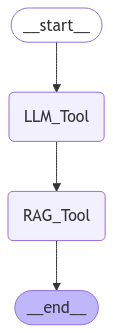

In [236]:
# 5. Display the graph
from IPython.display import Image, display

try:
    display(Image(my_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [238]:
# User query

user_input = "Name few Restaurants in Malleswaram serving Vegetarian food"
Agent_State["user_message"].append(user_input)

print(Agent_State)

defaultdict(<class 'list'>, {'user_message': ['Name few Restaurants in Malleswaram serving Vegetarian food']})


In [239]:
# Step 6: Run the graph

query = Agent_State

result = my_graph.invoke(query)

In [241]:
print(result)

Some restaurants in Malleswaram serving vegetarian food are:

1. Kadamba
2. Swati
3. Hallimane
4. Shiv Sagar
5. Al-Bek
6. Karnataka Biryani Point
7. Donne Biryani House
8. Veena Stores
9. CTR
10. Brahmins Tatte Idli
11. 1947
12. The Green Path Organic
13. Mint Masala


In [242]:
# User query

user_input = "Name few Restaurants in MG Road for breakfast"
Agent_State["user_message"].append(user_input)

print(Agent_State)

defaultdict(<class 'list'>, {'user_message': ['Name few Restaurants in Malleswaram serving Vegetarian food', 'Name few Restaurants in MG Road for breakfast'], 'agent_response': ['Some popular vegetarian restaurants in Malleswaram, Bangalore include Shri Sainath, MTR 24x7, and Adigas. These restaurants are known for their traditional South Indian and North Indian vegetarian cuisines.', 'Some restaurants in Malleswaram serving vegetarian food are:\n\n1. Kadamba\n2. Swati\n3. Hallimane\n4. Shiv Sagar\n5. Al-Bek\n6. Karnataka Biryani Point\n7. Donne Biryani House\n8. Veena Stores\n9. CTR\n10. Brahmins Tatte Idli\n11. 1947\n12. The Green Path Organic\n13. Mint Masala']})


In [243]:
query = Agent_State
for output in my_graph.stream(query):
  for key,value in output.items():
    print(f"here is output from {key}:")
    print(value)
    print("_______")
    print("\n")

here is output from LLM_Tool:
defaultdict(<class 'list'>, {'user_message': ['Name few Restaurants in Malleswaram serving Vegetarian food', 'Name few Restaurants in MG Road for breakfast'], 'agent_response': ['Some popular vegetarian restaurants in Malleswaram, Bangalore include Shri Sainath, MTR 24x7, and Adigas. These restaurants are known for their traditional South Indian and North Indian vegetarian cuisines.', 'Some restaurants in Malleswaram serving vegetarian food are:\n\n1. Kadamba\n2. Swati\n3. Hallimane\n4. Shiv Sagar\n5. Al-Bek\n6. Karnataka Biryani Point\n7. Donne Biryani House\n8. Veena Stores\n9. CTR\n10. Brahmins Tatte Idli\n11. 1947\n12. The Green Path Organic\n13. Mint Masala', "Some popular restaurants on MG Road for breakfast include Cafe Mondegar, Le Meridien's Oasis, and Aroma. They offer a wide variety of breakfast options, including Indian and international cuisines."]})
_______


here is output from RAG_Tool:
Some popular restaurants in MG Road for breakfast incl